In [206]:
import numpy as np 
from numpy import inf
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from math import sqrt
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.utils.data as utils
import time


In [2]:
SP=pd.read_csv('portfolio_equities.csv',delimiter=',',index_col='date')
SP_montly=pd.read_csv('portfolio_equities_monthly.csv',delimiter=',',index_col='date')
SP

,PERMNO,TICKER,COMNAM,PRC
date,,,,
12/31/1986,10333,XOMA,XOMA CORP,11.875
01/02/1987,10333,XOMA,XOMA CORP,12.250
01/05/1987,10333,XOMA,XOMA CORP,12.250
01/06/1987,10333,XOMA,XOMA CORP,12.000
01/07/1987,10333,XOMA,XOMA CORP,12.500
01/08/1987,10333,XOMA,XOMA CORP,12.500
01/09/1987,10333,XOMA,XOMA CORP,14.750
01/12/1987,10333,XOMA,XOMA CORP,15.750
01/13/1987,10333,XOMA,XOMA CORP,15.500


In [3]:
def get_equities_data(SP,permno):
    matrix = SP.loc[lambda SP: SP['PERMNO'] == permno]
    return abs(matrix['PRC'])

SP.dropna(inplace=True)
SP_montly.dropna(inplace=True)

permnos = SP_montly.drop_duplicates('PERMNO')
permnos = permnos['PERMNO'].values
tickers = SP_montly.drop_duplicates('TICKER')
tickers = tickers['TICKER'].values
    
print(permnos)
print(tickers)

[10333 12490 14593 17778 43449 48725 55976]
['XOMA' 'IBM' 'AAPL' 'BKHT' 'BRK' 'MCD' 'UNP' 'WMT']


In [41]:
matrix_daily = SP.loc[lambda SP: SP['PERMNO'] == permnos[0]]
index_daily = matrix_daily.index

matrix_monthly = SP_montly.loc[lambda SP_montly: SP_montly['PERMNO'] == permnos[0]]
index_monthly = matrix_monthly.index

columns = ['XOMA','IBM','AAPL','BRK','MCD','UNP','WMT']

df_daily = pd.DataFrame(index=index_daily, columns=columns)
df_daily = df_daily.fillna(0)

df_monthly = pd.DataFrame(index=index_monthly, columns=columns)
df_monthly = df_monthly.fillna(0)

def equity_to_df(SP, perm, df, columns):
    for i in range(len(columns)):
        df[columns[i]]= get_equities_data(SP, perm[i])
    return df

df_daily = equity_to_df(SP, permnos,df_daily ,columns)
"""
df_daily['XOMA'] = get_equities_data(SP,permnos[0])
df_daily['IBM'] = get_equities_data(SP,permnos[1])
df_daily['AAPL'] = get_equities_data(SP,permnos[2])
df_daily['BRK'] = get_equities_data(SP,permnos[3])
df_daily['MCD'] = get_equities_data(SP,permnos[4])
df_daily['UNP'] = get_equities_data(SP,permnos[5])
df_daily['WMT'] = get_equities_data(SP,permnos[6])
"""
df_monthly = equity_to_df(SP_montly, permnos, df_monthly, columns)
"""
df_monthly['XOMA'] = get_equities_data(SP_montly,permnos[0])
df_monthly['IBM'] = get_equities_data(SP_montly,permnos[1])
df_monthly['AAPL'] = get_equities_data(SP_montly,permnos[2])
df_monthly['BRK'] = get_equities_data(SP_montly,permnos[3])
df_monthly['MCD'] = get_equities_data(SP_montly,permnos[4])
df_monthly['UNP'] = get_equities_data(SP_montly,permnos[5])
df_monthly['WMT'] = get_equities_data(SP_montly,permnos[6])
"""

df_daily.fillna(value=0, inplace=True)
print(df_daily.isna().sum())
print(df_daily.min()) # the zero of BRK is dangerous to calculate its return need to change it by the median

df_daily['BRK'][df_daily['BRK'] == 0] = df_daily['BRK'].median()
print(df_daily.min())

XOMA    0
IBM     0
AAPL    0
BRK     0
MCD     0
UNP     0
WMT     0
dtype: int64
XOMA     0.2590
IBM     41.0000
AAPL    12.9375
BRK      0.0000
MCD     12.3800
UNP     33.6200
WMT     19.2500
dtype: float64
XOMA       0.2590
IBM       41.0000
AAPL      12.9375
BRK     2675.0000
MCD       12.3800
UNP       33.6200
WMT       19.2500
dtype: float64


In [42]:
ret_daily= df_daily.pct_change(1)
ret_daily = ret_daily.drop(ret_daily.index[[0]])

ret_monthly= df_monthly.pct_change(1)
ret_monthly = ret_monthly.drop(ret_monthly.index[[0]])

ret_daily.max()

XOMA    16.737351
IBM      0.131636
AAPL     0.332278
BRK      3.415663
MCD      0.108602
UNP      0.096618
WMT      0.124424
dtype: float64

In [6]:

#This code loads the totalReturns.csv file, 
#which has the dates in the first column,
#the data (in index level) for the four asset classes in columns 2 to 5
#and the risk-free rate (1-month T-bill rate) in column 6. 
S=pd.read_csv('totalReturns.csv',delimiter=',',index_col='Date')
S = S.drop('Unnamed: 6',1)

#compute returns
ret= S.pct_change(1) #take one month before in order to be able to calculate the first return
ret = ret.drop('1M T-bill rate',1)
Rf = S.iloc[:,-1].shift(1)/12
Rf = Rf.drop(Rf.index[[0]])
ret = ret.drop(ret.index[[0]])


Rf = Rf.drop(Rf.index[range(12*9)])
print(Rf)

#compute portfolio weights
roll_monthly_mean = ret_monthly.rolling(window=120,min_periods=120).mean() #rolling window = 12 month * 10 years of data to define returns of each portfolios
roll_monthly_std = ret_monthly.rolling(window=120,min_periods=120).std()
roll_monthly_cov = ret_monthly.rolling(window=120,min_periods=120).cov()
roll_Rf = Rf.rolling(window=120,min_periods=120).mean()

print(roll_monthly_mean)

Date
1/31/1987     0.004525
2/28/1987     0.004658
3/31/1987     0.004658
4/30/1987     0.004700
5/31/1987     0.004717
6/30/1987     0.004725
7/31/1987     0.004742
8/31/1987     0.005033
9/30/1987     0.005333
10/31/1987    0.005108
11/30/1987    0.004742
12/31/1987    0.004808
1/31/1988     0.004842
2/29/1988     0.004717
3/31/1988     0.004750
4/30/1988     0.004925
5/31/1988     0.005217
6/30/1988     0.005383
7/31/1988     0.005608
8/31/1988     0.005883
9/30/1988     0.006033
10/31/1988    0.006125
11/30/1988    0.006467
12/31/1988    0.006725
1/31/1989     0.006892
2/28/1989     0.007108
3/31/1989     0.007350
4/30/1989     0.007208
5/31/1989     0.007025
6/30/1989     0.006792
                ...   
9/30/2013     0.000017
10/31/2013    0.000042
11/30/2013    0.000058
12/31/2013    0.000058
1/31/2014     0.000033
2/28/2014     0.000042
3/31/2014     0.000042
4/30/2014     0.000025
5/31/2014     0.000025
6/30/2014     0.000033
7/31/2014     0.000025
8/31/2014     0.000025
9/30/2

In [7]:
ONES = np.ones(7)

dates = ret_monthly.iloc[119:].index.get_level_values(0)
Rf.index = ret_monthly.index
print(len(dates))

w = np.zeros((len(dates), 4, 7))
i = 0
for date in dates: 
    # esimation of parameters
    MU = roll_monthly_mean.loc[date].values
    STD = roll_monthly_std.loc[date].values
    SIGMA = roll_monthly_cov.loc[date].values
    INV_SIGMA = np.linalg.inv(SIGMA)
    #R0 = roll_Rf.loc[date]
    #i.e., estimation of risk premium (mu-R0)
    #An alternative is to esimate the expected return mu,
    #and to use the current risk-free rate to compute the weights.
    #In this second case, set: 
    R0 = Rf.loc[date]
    
    A = (ONES@INV_SIGMA)@ONES
    B = (ONES@INV_SIGMA)@MU
    C = (MU@INV_SIGMA)@MU
    DELTA = A*C-B**2
    
    # composition of portfolio
    w[i,0,:] = (INV_SIGMA@(MU-R0))/(B-A*R0) #TAN
    w[i,1,:] = (INV_SIGMA@ONES)/A # GMV
    tmp = 1/STD
    w[i,2,:] = tmp/tmp.sum() #RP
    w[i,3,:] = np.ones(7)/7 #EW
    i+=1
    

231



 (a) Time series of the portfolio weights:


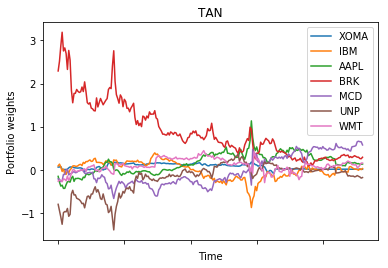

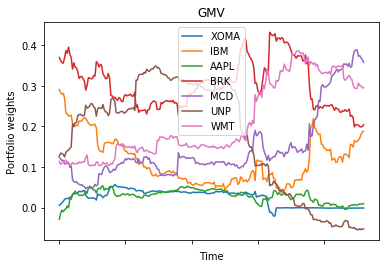

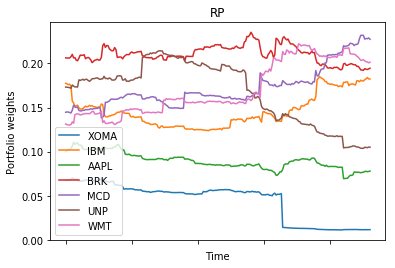

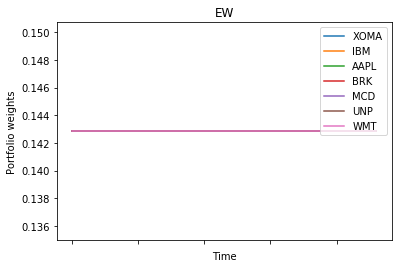

In [8]:
#plotting portfolios
asset_classes = columns
strategies = ['TAN','GMV','RP','EW']

print('\n (a) Time series of the portfolio weights:')
for i in range(len(strategies)): 
    df_w = pd.DataFrame(data=w[:,i,:],index=dates,columns=asset_classes)
    df_w.plot(title=strategies[i])
    plt.xlabel('Time')
    plt.ylabel('Portfolio weights')
    plt.legend(asset_classes, loc=0)
    plt.show()

In [9]:
#computing portfolio returns
dates_perf = ret_monthly.iloc[120:].index.get_level_values(0)

p_perf = np.zeros((len(dates_perf), 4))
for j in range(len(strategies)): 
    tmp = np.multiply(w[:-1,j,:],ret_monthly.iloc[120:]) # :-1 means except the last
    p_perf[:,j] = tmp.sum(axis=1) # sum over each lines of the matrix and p_perf = returns on each portfolios [return port for each time, strategies]
    
df_p_perf = pd.DataFrame(data=p_perf,index=dates_perf,columns=strategies)

R0 = Rf.loc[dates_perf].mean()
M = df_p_perf.mean()
E = df_p_perf.mean()-R0
S = df_p_perf.std()
SR = E/S
index = ['Mean Return', 'Mean Excess Return', 'Std. Dev.', 'Sharpe Ratio']
pStats = pd.DataFrame({index[0] : M, 
                    index[1] : E,
                    index[2] : S, 
                    index[3] : SR
                      })
pStats = pStats.T
pStats = pStats.reindex(index)

index_a = [' (ann.)']*4
index_a = [x+y for x, y in zip(index, index_a)]
pStats_a = pd.DataFrame({index_a[0] : M*12,
                    index_a[1] : E*12,
                    index_a[2] : S*np.sqrt(12),
                    index_a[3] : SR*np.sqrt(12)
                      })
pStats_a = pStats_a.T
pStats_a = pStats_a.reindex(index_a)

print('\n (b) Mean, standard deviation and Sharpe ratio of portfolio returns:')
print('\n The monthly return statistics of the strategies are:')
display(np.around(pStats,6))
print('\n The annualized return statistics of the strategies are:')
display(np.around(pStats_a,6))


 (b) Mean, standard deviation and Sharpe ratio of portfolio returns:

 The monthly return statistics of the strategies are:


,TAN,GMV,RP,EW
Mean Return,0.005595,0.006764,0.010065,0.014915
Mean Excess Return,0.003775,0.004943,0.008245,0.013095
Std. Dev.,0.109831,0.045772,0.053921,0.100922
Sharpe Ratio,0.034369,0.107995,0.152907,0.129751



 The annualized return statistics of the strategies are:


,TAN,GMV,RP,EW
Mean Return (ann.),0.067143,0.081164,0.120784,0.178982
Mean Excess Return (ann.),0.045297,0.059318,0.098939,0.157136
Std. Dev. (ann.),0.380466,0.158559,0.186788,0.349603
Sharpe Ratio (ann.),0.119058,0.374107,0.529684,0.449470



 (d) Minimum-variance frontier and location of the 4 portfolios using ex-post performance:


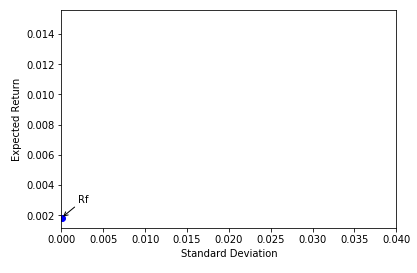

In [10]:
#MV frontiers
Mup = np.linspace(0.003,0.009,1000)
MU = ret_monthly.loc[dates_perf].mean().values
SIGMA = ret_monthly.loc[dates_perf].cov().values
INV_SIGMA = np.linalg.inv(SIGMA)


A = (ONES@INV_SIGMA)@ONES
B = (ONES@INV_SIGMA)@MU
C = (MU@INV_SIGMA)@MU
DELTA = A*C-B**2

Sigmap = np.sqrt((A*np.multiply(Mup,Mup)-2*B*Mup+C)/DELTA)

plt.plot(Sigmap,Mup)
plt.xlabel('Standard Deviation')
plt.ylabel('Expected Return')
plt.plot(S,M,'ro')
plt.plot(0.0001,R0,'bo')
plt.xlim(0, 0.04)


plt.annotate('TAN', xy=(S[0],M[0]), xytext=(S[0]-.003, M[0]-.0015),
            arrowprops=dict(arrowstyle="->")
            )
plt.annotate('GMV', xy=(S[1],M[1]), xytext=(S[1]-.003, M[1]-.0015),
            arrowprops=dict(arrowstyle="->")
            )
plt.annotate('RP', xy=(S[2],M[2]), xytext=(S[2]-.003, M[2]+.0015),
            arrowprops=dict(arrowstyle="->")
            )
plt.annotate('EW', xy=(S[3],M[3]), xytext=(S[3]-.003, M[3]+.0015),
            arrowprops=dict(arrowstyle="->")
            )
plt.annotate('Rf', xy=(0, R0), xytext=(.001+.001, R0+.001),
            arrowprops=dict(arrowstyle="->")          
            )

print('\n (d) Minimum-variance frontier and location of the 4 portfolios using ex-post performance:')
plt.show()


 (e) Cumulative performance of 1$ invested in December 1987:


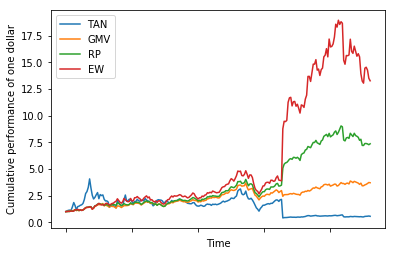

In [11]:
#total return index
dates_cumperf = ret_monthly.iloc[119:].index.get_level_values(0)
ones = np.ones((1,4))

cumperf = np.cumprod(np.concatenate((ones,1 + p_perf),axis=0),axis=0) #cumprod because when we win money we reinvest it directly
df_cumperf = pd.DataFrame(data=cumperf,index=dates_cumperf,columns=strategies)

df_cumperf.plot()
plt.xlabel('Time')
plt.ylabel('Cumulative performance of one dollar')
plt.legend(strategies, loc=0)


print('\n (e) Cumulative performance of 1$ invested in December 1987:')
plt.show()


In [12]:

labels = np.zeros(len(p_perf))
for i in range(len(p_perf)): # the goal is to define the classification of the labels for the crossentropy loss
    opt = np.argmax(p_perf[i,:])
    labels[i] = opt
print(labels.shape)
print(labels)

(230,)
[0. 0. 0. 1. 0. 0. 3. 3. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 2. 1. 3. 3. 0. 0.
 3. 0. 1. 1. 3. 3. 3. 2. 2. 0. 3. 0. 3. 3. 0. 1. 1. 0. 3. 0. 0. 1. 0. 0.
 3. 1. 3. 3. 1. 0. 1. 0. 0. 1. 3. 0. 3. 1. 3. 0. 1. 1. 0. 0. 0. 3. 2. 0.
 0. 3. 0. 3. 3. 2. 3. 0. 2. 1. 0. 1. 0. 2. 2. 0. 3. 3. 2. 1. 2. 3. 3. 3.
 0. 1. 1. 0. 3. 0. 3. 2. 3. 0. 3. 1. 1. 1. 0. 2. 0. 1. 0. 0. 3. 3. 0. 1.
 3. 0. 0. 3. 0. 0. 1. 0. 3. 0. 0. 0. 1. 1. 3. 0. 3. 2. 3. 0. 1. 0. 1. 2.
 3. 2. 0. 0. 0. 3. 3. 0. 0. 1. 3. 2. 0. 0. 3. 3. 0. 0. 1. 3. 3. 2. 0. 3.
 3. 0. 2. 3. 3. 2. 0. 0. 0. 2. 1. 0. 3. 0. 3. 3. 1. 3. 3. 0. 1. 1. 3. 2.
 1. 2. 3. 0. 3. 1. 3. 0. 1. 0. 3. 3. 3. 3. 1. 0. 0. 1. 2. 3. 1. 3. 3. 1.
 3. 0. 0. 2. 3. 3. 1. 0. 1. 3. 0. 1. 0. 2.]


In [142]:
fama_daily = pd.read_csv('fama_french.csv',delimiter=',')
rf_daily = fama_daily['RF']

dates = fama_daily['date']
dates = pd.to_datetime(dates,format='%Y%m%d').dt.strftime('%m/%d/%Y')

rf_daily.index = dates

target_dates = ret_daily.index

Rf_fama = rf_daily.loc[target_dates]

print(Rf_fama.shape, df_daily.shape)
print(Rf_fama)

(7939,) (7940, 7)
date
01/02/1987    0.020
01/05/1987    0.020
01/06/1987    0.020
01/07/1987    0.020
01/08/1987    0.020
01/09/1987    0.020
01/12/1987    0.020
01/13/1987    0.020
01/14/1987    0.020
01/15/1987    0.020
01/16/1987    0.020
01/19/1987    0.020
01/20/1987    0.020
01/21/1987    0.020
01/22/1987    0.020
01/23/1987    0.020
01/26/1987    0.020
01/27/1987    0.020
01/28/1987    0.020
01/29/1987    0.020
01/30/1987    0.020
02/02/1987    0.023
02/03/1987    0.023
02/04/1987    0.023
02/05/1987    0.023
02/06/1987    0.023
02/09/1987    0.023
02/10/1987    0.023
02/11/1987    0.023
02/12/1987    0.023
              ...  
05/18/2018    0.006
05/21/2018    0.006
05/22/2018    0.006
05/23/2018    0.006
05/24/2018    0.006
05/25/2018    0.006
05/29/2018    0.006
05/30/2018    0.006
05/31/2018    0.006
06/01/2018    0.006
06/04/2018    0.006
06/05/2018    0.006
06/06/2018    0.006
06/07/2018    0.006
06/08/2018    0.006
06/11/2018    0.006
06/12/2018    0.006
06/13/2018    0.0

In [143]:
#print(max(Rf))
#print(min(Rf))

print(max(Rf_fama))
print(min(Rf_fama))

0.036000000000000004
0.0


In [144]:
def dailytosomething(df,rf,number):
    new_df = df.iloc[::number,:]
    new_rf = rf.iloc[::number]
    new_rf = new_rf.iloc[:].shift(1)#/12
    ret= new_df.pct_change(1)
    ret = ret.drop(ret.index[[0]])
    rf_final = new_rf.drop(new_rf.index[[0]])
    return ret,rf_final

number = 5
ret_weekly, Rf_weekly = dailytosomething(df_daily,Rf_fama,number)
print(ret_weekly.shape)
print(Rf_weekly.shape)

Rf_weekly = ((1 + Rf_weekly)**number) -1


(1587, 7)
(1587,)


In [145]:
#compute portfolio weights
rolling_window_step = 140

roll_weekly_mean = ret_weekly.rolling(window=rolling_window_step,min_periods=rolling_window_step).mean() #rolling window = 12 month * 10 years of data to define returns of each portfolios
roll_weekly_std = ret_weekly.rolling(window=rolling_window_step,min_periods=rolling_window_step).std()
roll_weekly_cov = ret_weekly.rolling(window=rolling_window_step,min_periods=rolling_window_step).cov()
roll_weekly_Rf = Rf_weekly.rolling(window=rolling_window_step,min_periods=rolling_window_step).mean()


1448

 (a) Time series of the portfolio weights:


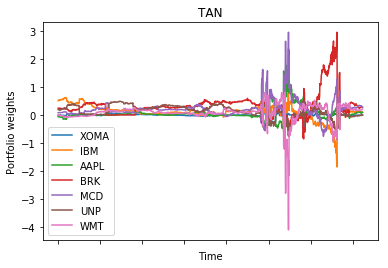

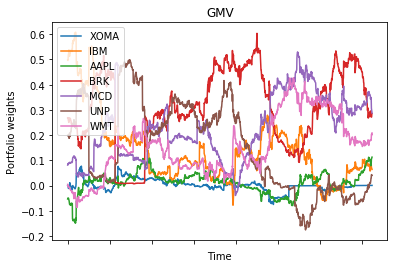

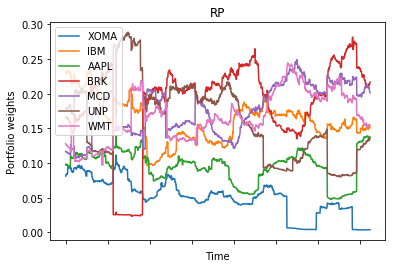

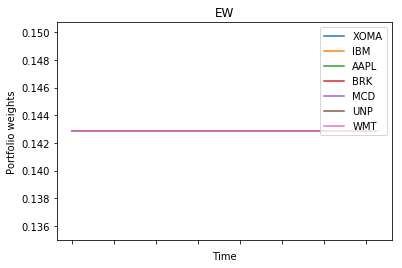

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


In [146]:
ONES = np.ones(7)

dates = ret_weekly.iloc[(rolling_window_step-1):].index.get_level_values(0)
print(len(dates))
Rf_weekly.index = ret_weekly.index

w = np.zeros((len(dates), 4, 7))
i = 0
for date in dates: 
    # esimation of parameters
    MU = roll_weekly_mean.loc[date].values
    STD = roll_weekly_std.loc[date].values
    SIGMA = roll_weekly_cov.loc[date].values
    INV_SIGMA = np.linalg.inv(SIGMA)
    #R0 = roll_Rf.loc[date]
    #i.e., estimation of risk premium (mu-R0)
    #An alternative is to esimate the expected return mu,
    #and to use the current risk-free rate to compute the weights.
    #In this second case, set: 
    R0 = Rf_weekly.loc[date]
    
    A = (ONES@INV_SIGMA)@ONES
    B = (ONES@INV_SIGMA)@MU
    C = (MU@INV_SIGMA)@MU
    DELTA = A*C-B**2
    
    # composition of portfolio
    w[i,0,:] = (INV_SIGMA@(MU-R0))/(B-A*R0) #TAN
    w[i,1,:] = (INV_SIGMA@ONES)/A # GMV
    tmp = 1/STD
    w[i,2,:] = tmp/tmp.sum() #RP
    w[i,3,:] = np.ones(7)/7 #EW
    i+=1
    

#plotting portfolios
asset_classes = columns
strategies = ['TAN','GMV','RP','EW']

print('\n (a) Time series of the portfolio weights:')
for i in range(len(strategies)): 
    df_w = pd.DataFrame(data=w[:,i,:],index=dates,columns=asset_classes)
    df_w.plot(title=strategies[i])
    plt.xlabel('Time')
    plt.ylabel('Portfolio weights')
    plt.legend(asset_classes, loc=0)
    plt.show()
print(sum(np.isnan(w)))

In [147]:
#computing portfolio returns
dates_perf = ret_weekly.iloc[rolling_window_step:].index.get_level_values(0)

p_perf = np.zeros((len(dates_perf), 4))
for j in range(len(strategies)): 
    tmp = np.multiply(w[:-1,j,:],ret_weekly.iloc[rolling_window_step:]) # :-1 means except the last
    p_perf[:,j] = tmp.sum(axis=1) # sum over each lines of the matrix and p_perf = returns on each portfolios [return port for each time, strategies]
    
df_p_perf = pd.DataFrame(data=p_perf,index=dates_perf,columns=strategies)

R0 = Rf_weekly.loc[dates_perf].mean()
M = df_p_perf.mean()
E = df_p_perf.mean()-R0
S = df_p_perf.std()
SR = E/S
index = ['Mean Return', 'Mean Excess Return', 'Std. Dev.', 'Sharpe Ratio']
pStats = pd.DataFrame({index[0] : M, 
                    index[1] : E,
                    index[2] : S, 
                    index[3] : SR
                      })
pStats = pStats.T
pStats = pStats.reindex(index)

index_a = [' (ann.)']*4
index_a = [x+y for x, y in zip(index, index_a)]
pStats_a = pd.DataFrame({index_a[0] : M*12, # change *12 cause were not anymore annual
                    index_a[1] : E*12,  # change *12 cause were not anymore annual
                    index_a[2] : S*np.sqrt(12),  # change *12 cause were not anymore annual
                    index_a[3] : SR*np.sqrt(12)  # change *12 cause were not anymore annual
                      })
pStats_a = pStats_a.T
pStats_a = pStats_a.reindex(index_a)

print('\n (b) Mean, standard deviation and Sharpe ratio of portfolio returns:')
print('\n The monthly return statistics of the strategies are:')
display(np.around(pStats,6))
print('\n The annualized return statistics of the strategies are:')
display(np.around(pStats_a,6))




 (b) Mean, standard deviation and Sharpe ratio of portfolio returns:

 The monthly return statistics of the strategies are:


,TAN,GMV,RP,EW
Mean Return,0.003948,0.002221,0.003137,0.004993
Mean Excess Return,-0.052736,-0.054463,-0.053547,-0.051690
Std. Dev.,0.058589,0.045490,0.037750,0.072488
Sharpe Ratio,-0.900095,-1.197248,-1.418447,-0.713088



 The annualized return statistics of the strategies are:


,TAN,GMV,RP,EW
Mean Return (ann.),0.047381,0.026650,0.037646,0.059921
Mean Excess Return (ann.),-0.632826,-0.653557,-0.642561,-0.620286
Std. Dev. (ann.),0.202958,0.157583,0.130771,0.251106
Sharpe Ratio (ann.),-3.118020,-4.147387,-4.913643,-2.470211



 (d) Minimum-variance frontier and location of the 4 portfolios using ex-post performance:


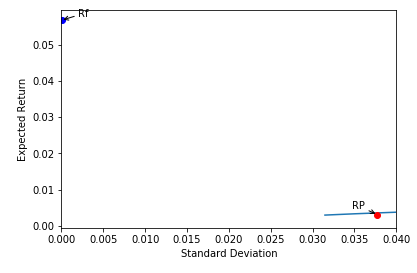

In [148]:
#MV frontiers
Mup = np.linspace(0.003,0.009,1000)
MU = ret_weekly.loc[dates_perf].mean().values
SIGMA = ret_weekly.loc[dates_perf].cov().values
INV_SIGMA = np.linalg.inv(SIGMA)


A = (ONES@INV_SIGMA)@ONES
B = (ONES@INV_SIGMA)@MU
C = (MU@INV_SIGMA)@MU
DELTA = A*C-B**2

Sigmap = np.sqrt((A*np.multiply(Mup,Mup)-2*B*Mup+C)/DELTA)

plt.plot(Sigmap,Mup)
plt.xlabel('Standard Deviation')
plt.ylabel('Expected Return')
plt.plot(S,M,'ro')
plt.plot(0.0001,R0,'bo')
plt.xlim(0, 0.04)


plt.annotate('TAN', xy=(S[0],M[0]), xytext=(S[0]-.003, M[0]-.0015),
            arrowprops=dict(arrowstyle="->")
            )
plt.annotate('GMV', xy=(S[1],M[1]), xytext=(S[1]-.003, M[1]-.0015),
            arrowprops=dict(arrowstyle="->")
            )
plt.annotate('RP', xy=(S[2],M[2]), xytext=(S[2]-.003, M[2]+.0015),
            arrowprops=dict(arrowstyle="->")
            )
plt.annotate('EW', xy=(S[3],M[3]), xytext=(S[3]-.003, M[3]+.0015),
            arrowprops=dict(arrowstyle="->")
            )
plt.annotate('Rf', xy=(0, R0), xytext=(.001+.001, R0+.001),
            arrowprops=dict(arrowstyle="->")          
            )

print('\n (d) Minimum-variance frontier and location of the 4 portfolios using ex-post performance:')
plt.show()





 (e) Cumulative performance of 1$ invested in December 1987:


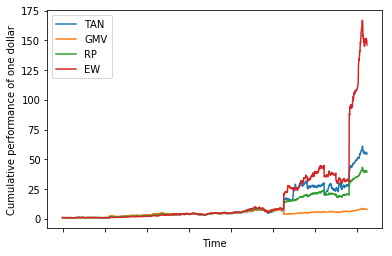

In [149]:
#total return index
dates_cumperf = ret_weekly.iloc[(rolling_window_step-1):].index.get_level_values(0)
ones = np.ones((1,4))

cumperf = np.cumprod(np.concatenate((ones,1 + p_perf),axis=0),axis=0) #cumprod because when we win money we reinvest it directly
df_cumperf = pd.DataFrame(data=cumperf,index=dates_cumperf,columns=strategies)

#df_cumperf.drop(columns=['TAN'],inplace=True)
df_cumperf.plot()
plt.xlabel('Time')
plt.ylabel('Cumulative performance of one dollar')
strategies = ['TAN','GMV','RP','EW']
#strategies = ['GMV','RP','EW']
plt.legend(strategies, loc=0)
#plt.ylim([-20,50])


print('\n (e) Cumulative performance of 1$ invested in December 1987:')
plt.show()


In [177]:
labels = np.zeros(len(p_perf))
for i in range(len(p_perf)): # the goal is to define the classification of the labels for the crossentropy loss
    opt = np.argmax(p_perf[i,:])
    labels[i] = opt
print(labels.shape)
print(labels)

print(sum(labels == 0))
print(sum(labels == 1))
print(sum(labels == 2))
print(sum(labels == 3))

#starting date of labels : 10/13/1989
print(roll_weekly_mean.iloc[rolling_window_step])

#starting date of our inputs : 10/06/1989
print(roll_weekly_mean.iloc[rolling_window_step-1])

(1447,)
[0. 3. 0. ... 0. 3. 0.]
414
333
131
569
XOMA    0.007543
IBM    -0.000833
AAPL    0.003246
BRK     0.008275
MCD    -0.003220
UNP     0.001702
WMT     0.000665
Name: 10/13/1989, dtype: float64
XOMA    0.008426
IBM    -0.000297
AAPL    0.004348
BRK     0.009119
MCD    -0.002455
UNP     0.002426
WMT     0.001451
Name: 10/06/1989, dtype: float64


In [190]:
ret_daily_input = ret_daily.loc['10/06/1989':]
print(ret_daily.shape[0]-ret_daily_input.shape[0])

rolling_window_step_daily = rolling_window_step * 5 

roll_daily_mean = ret_daily.rolling(window=rolling_window_step_daily,min_periods=rolling_window_step_daily).mean()
roll_daily_std = ret_daily.rolling(window=rolling_window_step_daily,min_periods=rolling_window_step_daily).std()
roll_Rf_daily_mean = Rf_fama.rolling(window=rolling_window_step_daily,min_periods=rolling_window_step_daily).mean()
print(ret_daily.iloc[rolling_window_step_daily-1])

def column_names(tickers,original =False, mean= False, std=False):
    res = []
    for t in tickers: 
        if original:
            res.append(t)
        if mean:
            res.append(t+"_mean")
        if std:
            res.append(t+"_std")
    return res

dates = ret_daily.iloc[rolling_window_step_daily-1:].index.get_level_values(0)
input_price = pd.DataFrame(ret_daily.iloc[rolling_window_step_daily-1:].values,columns=columns).set_index(dates)
input_mean = pd.DataFrame(roll_daily_mean[rolling_window_step_daily-1:].values,columns=column_names(columns, mean= True)).set_index(dates)
input_std = pd.DataFrame(roll_daily_std[rolling_window_step_daily-1:].values,columns=column_names(columns, std=True)).set_index(dates)

concat = pd.concat([input_price, input_mean, input_std], axis=1)
inputs = concat[column_names(columns, True, True, True)][:-number] #can not predict the last horizon
inputs['Rf'] = roll_Rf_daily_mean[rolling_window_step_daily-1:]

lstm_inputs = inputs.values.reshape((int(len(inputs)/5),5,22))
print("dataframe original shape", inputs.shape, "reshaped to ", lstm_inputs.shape )


699
XOMA    0.016667
IBM     0.000000
AAPL    0.057692
BRK     0.009742
MCD     0.012552
UNP    -0.003195
WMT     0.029586
Name: 10/06/1989, dtype: float64
dataframe original shape (7235, 22) reshaped to  (1447, 5, 22)


In [236]:
from sklearn.model_selection import train_test_split

print(labels.shape,lstm_inputs.shape)
X_train, X_test, y_train, y_test = train_test_split(lstm_inputs,labels, test_size=0.25)

print(X_train.shape, X_test.shape)

(1447,) (1447, 5, 22)
(1085, 5, 22) (362, 5, 22)


In [237]:
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_train = X_train.permute(1,0,2)

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()
X_test = X_test.permute(1,0,2)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([5, 1085, 22]) torch.Size([1085])
torch.Size([5, 362, 22]) torch.Size([362])


In [238]:
batch_dim = 3 #diviseur de valloader
traindataset = utils.TensorDataset(X_train.permute(1,0,2), y_train)
trainloader = utils.DataLoader(traindataset, batch_size=batch_dim, shuffle=True)

testdataset = utils.TensorDataset(X_test.permute(1,0,2), y_test)
testloader = utils.DataLoader(testdataset, batch_size=batch_dim, shuffle=True)

In [239]:
#let's define the lSTM network 

    
class LSTM(nn.Module):

    def __init__(self,input_size,output_size,batch_size,num_layers,hidden_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_size = batch_size

        # The LSTM takes features as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(input_size, hidden_size)

        # The linear layer that maps from hidden state space to output space
        self.hidden2output = nn.Linear(hidden_size, output_size)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_size),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_size))

    def forward(self, input_seq):
        
        output_seq, self.hidden = self.lstm(input_seq, self.hidden)#, None)
        last_output = output_seq[-1]
        output = self.hidden2output(last_output)
        
        return output
    
    def predict(self,x):
        out = self.forward(x)
        return out
        
    

In [240]:
from torch import optim

lr = 0.0001

print(X_train.shape[2])
lstm = LSTM(input_size = X_train.shape[2], output_size = 4, batch_size=batch_dim,num_layers=1,hidden_size = 300)
optimizer = optim.Adam(lstm.parameters(), lr=lr,weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

22


In [241]:
epochs = 50
steps = 0
print_every = 323
running_loss = 0

loss_train = []
loss_val = []
for e in range(epochs):
    start = time.time()
    
    total_train_loss=0
    steps_bis = 0
    #if (e+1)%10==0:
        #lr /= 2
        #optimizer = optim.Adam(lstm.parameters(), lr=lr,weight_decay=1e-4)

    for X_tr, y_tr in iter(trainloader):
        steps += 1
        steps_bis+=1
        
        # Clear stored gradient
        lstm.zero_grad()
        
        # Initialise hidden state
        # Don't do this if you want your LSTM to be stateful
        lstm.hidden = lstm.init_hidden()

        X_tr = X_tr.permute([1,0,2])
        #y_tr = y_tr.permute([1,0,2])
        
        if X_tr.shape[1] != batch_dim:
            continue

        in_train = Variable(X_tr)
        targets = Variable(y_tr).long()
        
        #optimizer.zero_grad()
        
        out = lstm.forward(in_train)
        
        loss = criterion(out, targets)
        
        loss.backward(retain_graph=True)
        optimizer.step()
        
        running_loss += loss.item()
    
        if steps % print_every == 0:
            stop = time.time()
            val_loss=0
            for ii, (X_validation, y_validation) in enumerate(testloader):
                    
                X_validation = X_validation.permute([1,0,2])
                #y_validation = y_validation.permute([1,0,2])
                    
                if X_validation.shape[1] != batch_dim:
                    continue
                    
                inputs = Variable(X_validation, volatile=True)
                predicted = lstm.predict(inputs)
                    
                val_loss+= (criterion(predicted,y_validation.long()).item())
                    
            print("Epoch: {}/{}..".format(e+1, epochs),
                "Validation loss: {:.4f}..".format(val_loss/ii),
                "Training loss: {:.4f}..".format(running_loss/print_every),
                "{:.4f} s/batch".format((stop - start)/print_every)
                )
                
            loss_val.append(val_loss/ii)
            loss_train.append(running_loss/print_every)
            running_loss = 0
            start = time.time()

/Users/4romain/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Epoch: 1/50.. Validation loss: 2.0559.. Training loss: 1.3174.. 0.0115 s/batch
Epoch: 2/50.. Validation loss: 2.5114.. Training loss: 1.2863.. 0.0094 s/batch
Epoch: 3/50.. Validation loss: 2.4600.. Training loss: 1.2818.. 0.0080 s/batch
Epoch: 4/50.. Validation loss: 2.6828.. Training loss: 1.2825.. 0.0069 s/batch
Epoch: 5/50.. Validation loss: 2.7500.. Training loss: 1.2780.. 0.0055 s/batch
Epoch: 6/50.. Validation loss: 3.2401.. Training loss: 1.2779.. 0.0043 s/batch
Epoch: 7/50.. Validation loss: 3.1609.. Training loss: 1.2748.. 0.0029 s/batch
Epoch: 8/50.. Validation loss: 3.8101.. Training loss: 1.2610.. 0.0016 s/batch
Epoch: 9/50.. Validation loss: 4.6494.. Training loss: 1.2755.. 0.0004 s/batch
Epoch: 9/50.. Validation loss: 6.0141.. Training loss: 1.2612.. 0.0108 s/batch
Epoch: 10/50.. Validation loss: 7.0075.. Training loss: 1.2402.. 0.0104 s/batch
Epoch: 11/50.. Validation loss: 7.7620.. Training loss: 1.2373.. 0.0087 s/batch
Epoch: 12/50.. Validation loss: 5.5462.. Training 

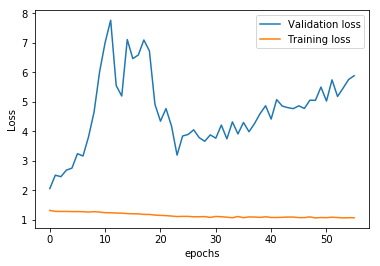

In [242]:
plt.plot(range(len(loss_val)),loss_val, label='Validation loss')
plt.plot(range(len(loss_train)),loss_train, label='Training loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [243]:
for ii, (x_validation,y_validation) in enumerate(trainloader):
    if ii == 1:
        break
    x_validation = x_validation.permute([1,0,2])           
    inputs = Variable(x_validation)
    predicted = lstm.predict(inputs).data.numpy()
    print(predicted)
    print(y_validation.data.numpy())

[[-0.51968956 -0.88007957 -1.0025165   2.252289  ]
 [ 1.0170325   0.91753954 -0.49598917 -1.6800318 ]
 [ 1.0130804   0.9323217  -0.5138494  -1.6843956 ]]
[3. 1. 1.]


## Comment incorporer matrix dans les features ??? TODO 


In [244]:
import igraph  as ig
import louvain as lv
import networkx as net
import cairocffi as cai

ModuleNotFoundError: No module named 'cairocffi'

In [16]:
N =400
T = 2000
def take_random(returns):
    return returns.sample(N,axis=1).sample(T,axis=0)
    
matrix_returns =take_random(logreturns)
#print(matrix_returns)
correl_matrix = np.corrcoef(matrix_returns,rowvar=0)
#print(correl_matrix.shape)
from numpy import linalg as LA

eigen,vectors = LA.eig(correl_matrix)

lam_max = 1 + N/T + 2*np.sqrt(N/T)
lam_min = 1 - N/T - 2*np.sqrt(N/T)


s = np.zeros(len(eigen))
for i in range(len(eigen)):
    s[i] = 1/(N/T)/(2*np.pi) * np.sqrt((lam_max-eigen[i])*(eigen[i]-lam_min))/eigen[i]
def compute_C_minus_C0(lambdas,v,lambda_plus):
    N = len(lambdas)
    C_clean= np.zeros((N,N))
    v_m = np.matrix(v)
    for i in range (N-1):
        if lambdas[i]>lambda_plus:
            C_clean = C_clean + lambdas[i]*np.dot(v_m[i,:].T, v_m[i,:])
    return np.abs(C_clean)

C_s = compute_C_minus_C0(eigen,vectors,lam_max)



mygraph = ig.Graph.Weighted_Adjacency(np.matrix(C_s).tolist())
myclusters=lv.find_partition(mygraph, lv.ModularityVertexPartition)
pd.DataFrame(myclusters.membership)

layout = mygraph.layout('kk')
width,height = 900,600
surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, width, height)
ctx = cairo.Context(surface)
ctx.scale(width,height)
ctx.rectangle(0, 0, 1, 1)
ctx.set_source_rgba(0,0,0,0)
ctx.fill()
ig.plot(mygraph,surface,bbox=(width,height),layout=layout)


NameError: name 'logreturns' is not defined